# Recommendation Engines

(This is for the Applied Data Science Group November/December 2017 session.)

This notebook tries to build a recommendation engine (the sort of which e-commerce sites use to recommend other items to you), for board-game data.
Matt Borthwick scraped the data from boardgamegeek.com.  This is an initial runthrough to check the quality of the data, and try to play with the distributions.  I'll try to check that the dataset seems sane, check the shape of the distributions.

## Possible questions:

I did a similar brainstorming exercise (without looking at the data) to what we did in the first week:

### Exploratory questions

1) What is the most popular game?
1a) Which has the highest average rating?
1b) Which has the most reviews?
(Also the antonyms)

2a) What is the most divisive game?
  (Greatest spread in review scores)

3) Data quality: NA, None, NAN
   Number of reviews per user?
   Number of reviews per game?
   Check scale of review scores

## Analysis/Modelling questions

4) Recommend new games based on similarities with others interests.

   Build clustering algorithm based on scores in games.
   *Assign each user a vector in Ngame-dim space.
   *Find users with similar vectors, based on dot-product.  (K-means or some other clustering)?
   *Remove games that are already reviewed, or with negative scores.
   *Recommend remaining game with highest score.

5) User analysis:
   Are there multiple audiences here? "Hardcore" vs "casual" to use the gamer terms.
   How many 1-review users are there? What games do they try out?
   What games do users with multiple reviews enjoy? "Amazon Top 500 reviewers"


In [1]:
#standard library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#makes larger plots
plt.rcParams['figure.figsize']=(10,6)

In [2]:
#read in the data.  (13MB or so)
#(N.B. I put Matt's header on it's own line, which is skipped, and added the UserID)
df=pd.read_csv('data/boardgame-ratings.csv',skiprows=1)

## Exploratory Analysis

I'm going to do a few things:
*check for NaN/missing values.
*check the scores look right
*check the numbers of reviews, and games.
*match up the names with the unique gameIDs (I'll find some missing entries here)
*plot the number of reviews/user and reviews/game.


In [3]:
#test for NaN
nan_array=np.isnan(df.values)
print('Number of NaN',np.sum(nan_array))
#check scale of review scores.
print('Max/min scores',df['rating'].min(),df['rating'].max())

Number of NaN 0
Max/min scores 1.0 10.0


In [5]:
#How many users, how many games?
#Find the unique entries in each list
users=df['userID'].unique()
games=df['gameID'].unique()

In [6]:
print('Number of unique users is:',len(users))
print('Number of unique games is:',len(games))
print('Total number of reviews is:',len(df))

Number of unique users is: 154655
Number of unique games is: 27
Total number of reviews is: 834415


In [7]:
#make a dict to convert game labels to names (provided by Matt)
#  Looks like we are missing the keys for 33154, 197376.  I made up some keys for plotting/naming purposes.
name_dict={11:"Bohnanza",
68448:"7 Wonders",
39856:"Dixit",
40692:"Small World",
31260:"Agricola",
148228:"Splendor",
13:"Catan",
178900:"Codenames",
34635:"Stone Age",
28143:"Race for the Galaxy",
129622:"Love Letter",
14996:"Ticket to Ride: Europe",
3076:"Puerto Rico",
30549:"Pandemic",
65244:"Forbidden Island",
478:"Citadels",
15987:"Arkham Horror",
110327:"Lords of Waterdeep",
36218:"Dominion",
2651:"Power Grid",
9209:"Ticket to Ride",
103:"Titan",
822:"Carcassonne",
2163:"Space Hulk",
1927:"Munchkin",
70323:"King of Tokyo",
33154:"NOTAGAME",
197376:"NOTAGAME2:NOT HARDER"}

#check name dictionary is working.
#I put in fake names earlier to find the missings ones
i=0
for num in games:
    print(i,num,name_dict[num])
    i+=1


0 14996 Ticket to Ride: Europe
1 68448 7 Wonders
2 13 Catan
3 31260 Agricola
4 178900 Codenames
5 9209 Ticket to Ride
6 30549 Pandemic
7 129622 Love Letter
8 36218 Dominion
9 3076 Puerto Rico
10 2651 Power Grid
11 110327 Lords of Waterdeep
12 822 Carcassonne
13 478 Citadels
14 39856 Dixit
15 103 Titan
16 148228 Splendor
17 40692 Small World
18 11 Bohnanza
19 28143 Race for the Galaxy
20 34635 Stone Age
21 1927 Munchkin
22 15987 Arkham Horror
23 70323 King of Tokyo
24 33154 NOTAGAME
25 2163 Space Hulk
26 197376 NOTAGAME2:NOT HARDER


In [8]:
#Number of games with missing names
msk1=df['gameID']==33154
msk2=df['gameID']==197376
print(np.sum(msk1),np.sum(msk2))

3699 91


### Number of reviews/user and reviews/game

In [9]:
avg_num_reviews=len(df)/len(users)
print(avg_num_reviews)

5.395331544405289


In [ ]:
So on average, each user reviews 5 games.  Let's try to build a histogram of users with a given number of reviews.  (and then the same with games)

In [10]:
#others mentioned issues with looping. let's also try a straightforward approach.
#took a minute or two - untenable for only 1000 users!

#df_user=pd.DataFrame(columns=['Ngames'],index=users)
#On reflection, reshaping would be super helpful on this data set.  Use 27 columns with one for each game, with a column for each score.      
# for user in users[0:4]:
#     print(user)
#     print('Ngames=',np.sum(df['userID']==user))

#this took a few seconds.
user_review_counts=df.groupby(['userID']).count()
#note that there really are users with ids going from 1 to 1000, its not a screwup.


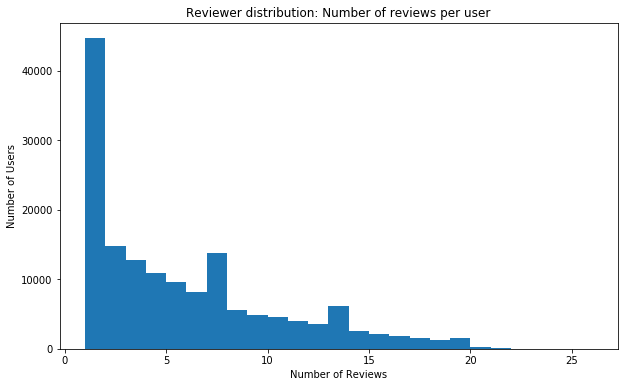

In [11]:
#plt.figure(figsize=(12,9))
plt.figure()
plt.hist(user_review_counts.iloc[:,0].values,bins=np.arange(1,27))
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users')
plt.title('Reviewer distribution: Number of reviews per user')
plt.show()

In [12]:
#find the counts of reviews for each game.
game_review_counts=df.groupby(['gameID']).count()
#make a list matching up gameIDs and names.  Use that list as a new index
new_index=[]
for ind in game_review_counts.index:
    new_index.append(name_dict[ind])

game_review_counts.index=new_index

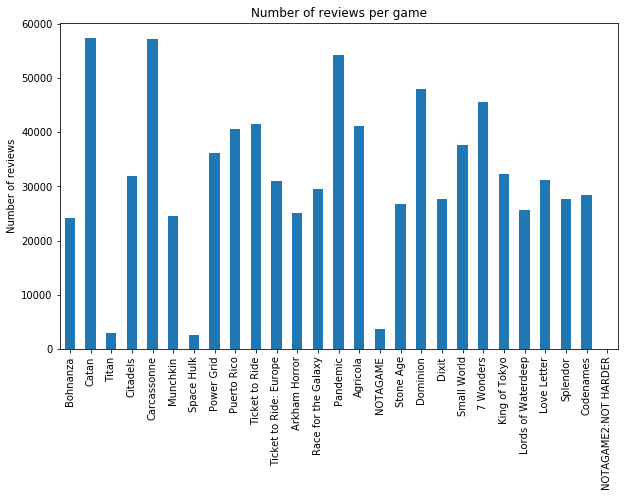

In [13]:
plt.figure()
game_review_counts.iloc[:,1].plot('bar')
plt.ylabel('Number of reviews')
plt.title('Number of reviews per game')
plt.show()

So, only a few games with less than 10000 reviews.  What I've called "NOTAGAME", ID=197376, only has 91 reviews, far fewever than everything else.
From the point of view of the exercise, it's probably worth keeping that game, to let people consider the value in keeping that data point.
Otherwise, looks fairly balanced, with a few cult classics, or new games in there.

Lets also try to look at the distributions of scores.  I'll try to make a box-plot.
That will let me check the distributions in an easy manner.
I'll pivot the data frame to make rows users, columns be games, with the entries given by the score. 

## Next steps - transforming the data

Rearranging the data to use the gameIDs as columns would make sense for recommendation.
For this data set, with 27 dim that's should be no problem. (Another question on what is best to do with thousands of entries).
This would also make it easier to look at histograms on a per-game basis.
I'm nigh certain pandas has a reshape function to do exactly this.  Pivot maybe?
(http://pandas.pydata.org/pandas-docs/stable/reshaping.html)

In [14]:
#make a small dataframe for debugging purposes
#df_small=df.iloc[0:1000]
df_pivot=df.pivot(index='userID',columns='gameID',values='rating')
df_pivot=df_pivot.rename(columns=name_dict)
df_pivot.head()

gameID,Bohnanza,Catan,Titan,Citadels,Carcassonne,Munchkin,Space Hulk,Power Grid,Puerto Rico,Ticket to Ride,...,Dominion,Dixit,Small World,7 Wonders,King of Tokyo,Lords of Waterdeep,Love Letter,Splendor,Codenames,NOTAGAME2:NOT HARDER
userID,,,,,,,,,,,,,,,,,,,,,
1,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,...,7.0,NaN,8.5,6.0,NaN,NaN,7.0,7.0,NaN,NaN
2,7.0,7.0,NaN,NaN,NaN,NaN,NaN,7.6,NaN,NaN,...,NaN,NaN,7.0,7.5,7.0,9.0,NaN,8.0,8.0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
?df.boxplot

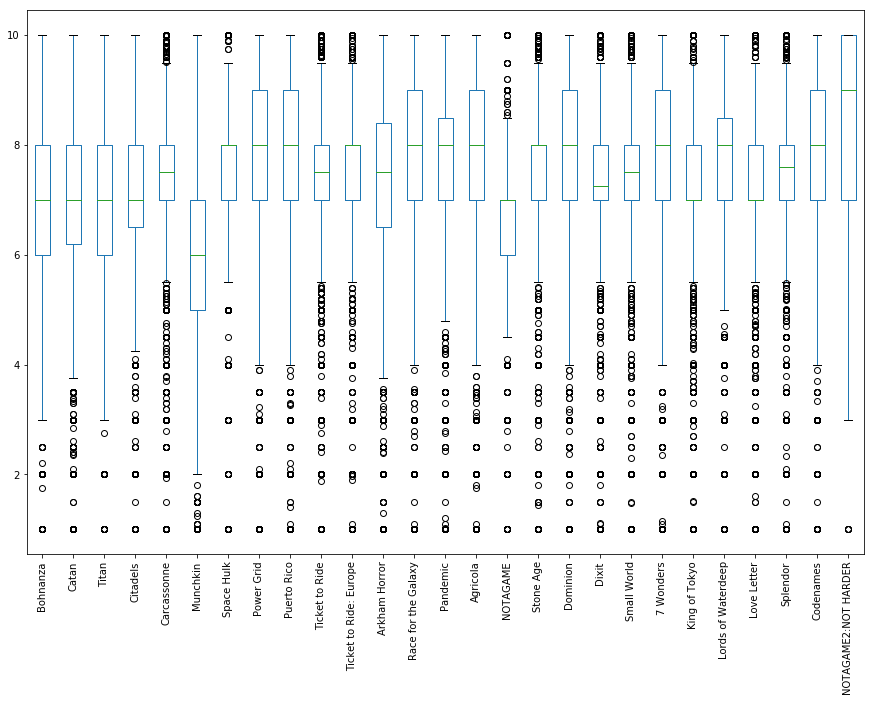

In [15]:
plt.figure(figsize=(15,10))
game_review_counts=df_pivot.boxplot(rot=90,grid=False)
plt.show()

(I'll imitate a plot I saw the more experienced folk do at the first finance-data meetup)
Try a correlation map based on columns to see how close the score distributions are.
I think this intuitively corresponds to: How much are the score distributions in one game similar to another?
Running across the rows would yield something analogous for users (but would take an age, since that is a 1E5 x 1E5 matrix).


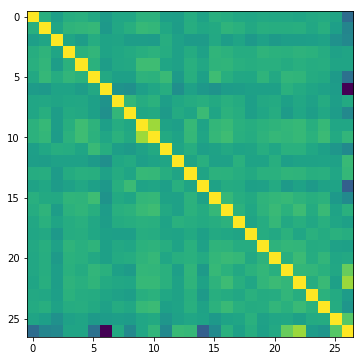

In [17]:
c=df_pivot.corr()

plt.figure()
plt.imshow(c)
plt.show()

In [18]:
#Barfs out a huge matrix of the actual numbers
print(c)

gameID                  Bohnanza     Catan     Titan  Citadels  Carcassonne  \
gameID                                                                        
Bohnanza                1.000000  0.275602  0.147732  0.263456     0.279118   
Catan                   0.275602  1.000000  0.190735  0.313599     0.331462   
Titan                   0.147732  0.190735  1.000000  0.190885     0.132252   
Citadels                0.263456  0.313599  0.190885  1.000000     0.288211   
Carcassonne             0.279118  0.331462  0.132252  0.288211     1.000000   
Munchkin                0.222787  0.342792  0.252330  0.332790     0.290828   
Space Hulk              0.118314  0.093264  0.174868  0.180398     0.127795   
Power Grid              0.199727  0.211489  0.184370  0.208685     0.216945   
Puerto Rico             0.199268  0.269999  0.128380  0.234754     0.220236   
Ticket to Ride          0.295869  0.354393  0.128326  0.265353     0.392478   
Ticket to Ride: Europe  0.295632  0.334663  0.121828

So what does that tell us?  Very Little?  The one game with an obvious signal (and negative correlations), is the one with 91 reviews.
The games with high correlations are "Ticket to ride" and "Ticket to ride: Europe".  Otherwise, everything is hovering around a correlation of 0.2

As for building a dataset for recommendations engines, the low correlation might be good?  A high correlation implies that everyone likes the same games, in which case there is no space for a skillful recommendation.

The low correlation might also be an artifact of lots of reviewers with only a single review. Those entries will have little correlation with anyone else, and may artificially lower the scores?  

## Conclusions regarding state of data

The data does suggest some interesting questions on its own on the population of boardgamers.  There is also a matter of having some data cleaning/munging to do on the full data set.

The only thing that I really think needs fixing are the missing names for: 33154, 197376.

There are no obvious big red flags in terms of missing data, or wacky scales, or weird distributions.
The number of reviews per user is skewed towards new folks (not unreasonable, given how few people can stick at something as time intensive as playing and reviewing board games).

As always, looping is slow as a turned-over-turtle, and the arcane, built-in functions are super fast.
In this case "groupby" is the Pandas variant of the split-apply-combine paradigm I've seen used in R.

I think for analysis, it would be beneficial to reshape the dataframe/array, but that is probably best left to the participants, as is removing any data with few reviews.
Looking at the box-plots, the scores seem fairly high, which tallies with what Matt said about picking popular games.  There doesn't seem anything obviously wrong with the distributions (all zero, or all 10s).

